# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     |Description        |
|------------|-------------------|
| `Booking_ID` Unique identifier of the booking. |
| `no_of_adults` The number of adults. |
| `no_of_children` The number of children. |
| `no_of_weekend_nights` Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` Number of week nights (Monday to Friday). |
| `type_of_meal_plan` Type of meal plan included in the booking. |
| `required_car_parking_space` Whether a car parking space is required. |
| `room_type_reserved` The type of room reserved. |
| `lead_time`  Number of days before the arrival date the booking was made. |
| `arrival_year` Year of arrival. |
| `arrival_month`  Month of arrival. |
| `arrival_date`  Date of the month for arrival. |
| `market_segment_type`  How the booking was made. |
| `repeated_guest` Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled`  Number of previous bookings that were canceled. |
| `avg_price_per_room` Average price per day of the booking. |
| `no_of_special_requests` Count of special requests made as part of the booking. |
| `booking_status` Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [31]:
# import libraries
import pandas as pd
import numpy as np
import sys 
import matplotlib.pyplot as plt
import seaborn as sns

# for splitting data
from sklearn.model_selection import train_test_split, cross_val_score

# for converting to numerical values
from sklearn.preprocessing import OneHotEncoder
# for transforming columns
from sklearn.compose import ColumnTransformer
# for imputing missing values
from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import RocCurveDisplay, accuracy_score, mean_absolute_error, precision_score, recall_score, roc_curve, roc_auc_score, classification_report, confusion_matrix 

%matplotlib inline

In [2]:
#import data
hotel = pd.read_csv("data/hotel_bookings.csv")
hotel.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


In [3]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          35862 non-null  float64
 2   no_of_children                        35951 non-null  float64
 3   no_of_weekend_nights                  35908 non-null  float64
 4   no_of_week_nights                     35468 non-null  float64
 5   type_of_meal_plan                     35749 non-null  object 
 6   required_car_parking_space            33683 non-null  float64
 7   room_type_reserved                    35104 non-null  object 
 8   lead_time                             35803 non-null  float64
 9   arrival_year                          35897 non-null  float64
 10  arrival_month                         35771 non-null  float64
 11  arrival_date   

In [4]:
hotel.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,35862.000000,35951.000000,35908.000000,35468.00000,33683.000000,35803.000000,35897.000000,35771.000000,35294.000000,35689.000000,35778.000000,35725.000000,35815.000000,35486.000000
mean,1.845017,0.105366,0.810209,2.20331,0.030698,85.276569,2017.820431,7.424031,15.605712,0.025666,0.023646,0.154458,103.418207,0.619343
std,0.518652,0.402871,0.870857,1.40989,0.172501,85.998845,0.383834,3.068277,8.743484,0.158140,0.370835,1.764805,35.057342,0.785849
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.00000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.00000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.00000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.00000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [5]:
#plt.subplot(2, 2, 1)
#plt.hist(hotel["booking_status"]);

#plt.subplot(2, 2, 2)
#plt.hist(hotel["type_of_meal_plan"].dropna().astype(str));

#plt.subplot(2, 2, 3)
#plt.hist(hotel["market_segment_type"].dropna().astype(str));

#plt.subplot(2, 2, 4)
#plt.hist(hotel["room_type_reserved"].dropna().astype(str));

In [6]:
print(hotel.isna().sum().
      sort_values(ascending=True))

print("\nMissing total: \n", hotel.isna().sum().sum())
print("\n5% of data: ", len(hotel)*0.05)

Booking_ID                                 0
booking_status                             0
no_of_children                           324
no_of_weekend_nights                     367
arrival_year                             378
no_of_adults                             413
avg_price_per_room                       460
lead_time                                472
no_of_previous_cancellations             497
arrival_month                            504
type_of_meal_plan                        526
no_of_previous_bookings_not_canceled     550
repeated_guest                           586
no_of_special_requests                   789
no_of_week_nights                        807
arrival_date                             981
room_type_reserved                      1171
market_segment_type                     1512
required_car_parking_space              2592
dtype: int64

Missing total: 
 12929

5% of data:  1813.75


A large amount of data is missing. To correctly fit the data, missing values need to be imputed.

In [7]:
hotel["booking_status"].unique()

array(['Not_Canceled', 'Canceled'], dtype=object)

In [8]:
# drop columns
hotel_new = hotel.drop(["Booking_ID", "arrival_year", "arrival_date", "arrival_month", "booking_status"], axis=1)

In [9]:
# create a dictionary fo  target variable
hotel_new["booking_status"] = hotel["booking_status"].replace(
     {"Canceled": 0, 
     "Not_Canceled": 1})

hotel_new.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,Online,0.0,0.0,0.0,106.68,1.0,1
2,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,Online,0.0,0.0,0.0,60.00,0.0,0
3,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,Online,0.0,0.0,0.0,100.00,0.0,0
4,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,Online,0.0,0.0,0.0,94.50,0.0,0


In [10]:
# encode categorical variables
#hotel_num = pd.DataFrame(pd.get_dummies(hotel_new, columns =["room_type_reserved",  "type_of_meal_plan",  "market_segment_type"]))

#hotel_num.head()

## Split Data

In [11]:
# 4 split
x = hotel_new.drop(["booking_status"], axis=1)
y = hotel_new["booking_status"]

np.random.seed(55)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print("Train:", x_train.shape, y_train.shape, "\nTest:", x_test.shape, y_test.shape)

Train: (29020, 14) (29020,) 
Test: (7255, 14) (7255,)


In [12]:
def encode_cat(data):
    columns_to_encode = ["room_type_reserved", "type_of_meal_plan", "market_segment_type"]
    for column in columns_to_encode:
        if column in data.columns:
            data = pd.DataFrame(pd.get_dummies(data, columns=[column]))
    return data

In [13]:
x_tr = encode_cat(x_train)
x_ts = encode_cat(x_test)

In [14]:
# impute missing values in train datasets
knn_imputer = KNNImputer(n_neighbors=11)

x_train = knn_imputer.fit_transform(x_tr)
x_test = knn_imputer.transform(x_ts)

np.isnan(x_train).sum(), np.isnan(x_test).sum()

(0, 0)

In [15]:
# function for renaming imputed dataset columns
def rename_col(encoded_data, imputed_data):
    
    imputed_df = pd.DataFrame(imputed_data)
    enc_col = list(encoded_data.columns)
    imp_col = list(imputed_df.columns)
    n = 0

    for i in enc_col:
        if n < len(imp_col):
            imputed_df.rename(columns={
                imp_col[n]:enc_col[n]
            }, 
            inplace=True)
            n = n + 1
            
    return imputed_df

In [16]:
# rename imputed columns based on encoded column names
x_test_df = rename_col(x_ts, x_test)
x_train_df = rename_col(x_tr, x_train)

x_test_df.sum().sum(), x_train_df.sum().sum(),

(1422004.1718181819, 5741308.793636363)

In [17]:
x_test.sum(),x_train.sum()

(1422004.1718181816, 5741308.793636365)

In [18]:
#x_test = x_test_df
#x_train = x_train_df

## Classification

In [19]:
clf = RandomForestClassifier(n_estimators=1000)

clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.8795313576843556

#### Cross Validation???

In [20]:
# correc???
x_encoded = encode_cat(x)
x_imputed = knn_imputer.fit_transform(x_encoded)

In [21]:
# 5 fold cross validation score on x dataset
cross_val_score(clf, x_imputed, y, cv=5)

array([0.87884218, 0.87980703, 0.87732598, 0.88187457, 0.87525844])

#### Confusion Matrix

In [22]:
y_preds = clf.predict(x_test)
# np.mean(y_preds == y_test)

In [23]:
conf_matrix = confusion_matrix(y_test, y_preds)
conf_matrix

array([[1741,  525],
       [ 349, 4640]], dtype=int64)

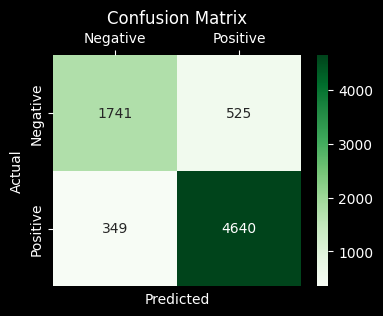

In [24]:
# Define class labels
conf_labels = ["Negative","Positive"]

# Create a heatmap with labels
plt.figure(figsize=(4, 3))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens",          xticklabels=conf_labels,  yticklabels=conf_labels).xaxis.tick_top()
    
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [25]:
True_Neg = 1741
False_Neg= 525
True_Pos = 4640
False_Pos = 349

print("Correct: ", (True_Neg+True_Pos), "\nIncorrect: ", (False_Neg+False_Pos))

Correct:  6381 
Incorrect:  874


The model predicted the booking status corectly 6381 times and incorrectly 874 times.

#### Classification Report

In [26]:
report_df = pd.DataFrame(classification_report(y_test, y_preds, target_names = ["", "score"],output_dict=True))
report_df.iloc[:, 1:3]

,score,accuracy
precision,0.898354,0.879531
recall,0.930046,0.879531
f1-score,0.913926,0.879531
support,4989.000000,0.879531


In [27]:
clf_acc = accuracy_score(y_test, y_preds)
clf_prec = precision_score(y_test, y_preds)
clf_recall = recall_score(y_test, y_preds)
clf_mean_err = mean_absolute_error(y_test, y_preds)

print("Accuracy:",clf_acc, "\nPrecision:",clf_prec, "\nRecall:",clf_recall,"\nMean error:", clf_mean_err)

Accuracy: 0.8795313576843556 
Precision: 0.8983543078412392 
Recall: 0.9300461014231309 
Mean error: 0.12046864231564439


In [28]:
print("mean_err using different method: ", (1-clf_acc))

mean_err using different method:  0.12046864231564436


#### ROC

In [29]:
y_pos_probs = clf.predict_proba(x_test)[:,1]
y_pos_probs[:5]
#pd.DataFrame(y_probs[:, 1])

array([0.487    , 1.       , 0.       , 0.88     , 0.7226857])

In [32]:
false_pos_rate, true_pos_rate, threshold = roc_curve(y_test, y_pos_probs)

auc = roc_auc_score(y_test, y_pos_probs)

roc_df = pd.DataFrame({"False": false_pos_rate, "True": true_pos_rate, "Thresh": threshold})

In [33]:
def fix_code(auc):
    for i in threshold:
        if i == auc:
            return threshold
        else:
            return 2
fix_code(auc)

2

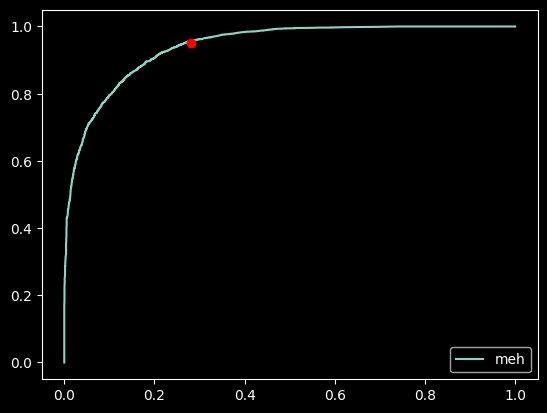

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(roc_df["False"], roc_df["True"])
plt.plot(0.28, 0.95, "ro")
plt.legend(["meh"], loc = "lower right")  # Corrected line
plt.show()

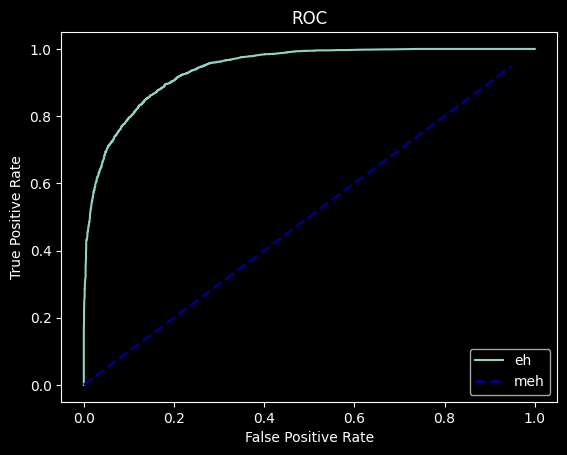

In [35]:
plt.figure()

plt.plot(false_pos_rate, true_pos_rate, label='ROC Curve')

plt.plot([0, 0.95], [0, 0.95], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

plt.legend(["eh", "meh"],loc="lower right")

plt.show()

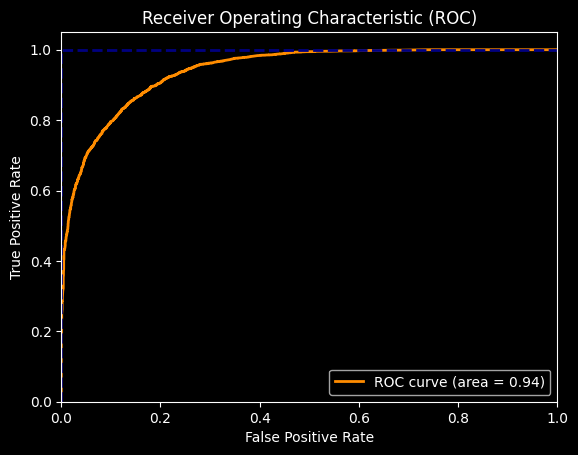

In [36]:
from sklearn.metrics import roc_auc_score

fpr = false_pos_rate
tpr = true_pos_rate
y_true = y_test
y_scores = y_pos_probs

roc_auc = roc_auc_score(y_true, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.step([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

plt.plot(roc_auc)
plt.show()

In [37]:
false_pos_rate, true_pos_rate,threshold

(array([0.        , 0.        , 0.        , ..., 0.76654898, 0.77890556,
        1.        ]),
 array([0.        , 0.13329325, 0.13369413, ..., 1.        , 1.        ,
        1.        ]),
 array([       inf, 1.        , 0.99994444, ..., 0.002     , 0.001     ,
        0.        ]))

In [38]:
h = list(x_tr.columns)
b = list(x_train_df.columns)
n = 0
   
for i in h:
    if n < len(b):  
        x_train_df.rename(columns={b[n]: h[n]}, inplace=True)  
        n=n+1

x_train_df.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'no_of_special_requests', 'room_type_reserved_Room_Type 1',
       'room_type_reserved_Room_Type 2', 'room_type_reserved_Room_Type 3',
       'room_type_reserved_Room_Type 4', 'room_type_reserved_Room_Type 5',
       'room_type_reserved_Room_Type 6', 'room_type_reserved_Room_Type 7',
       'type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2',
       'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected',
       'market_segment_type_Aviation', 'market_segment_type_Complementary',
       'market_segment_type_Corporate', 'market_segment_type_Offline',
       'market_segment_type_Online'],
      dtype='object')

In [39]:
#check total of each meal plan by room type
pd.crosstab(hotels["room_type_reserved"], hotels["type_of_meal_plan"])

NameError: name 'hotels' is not defined

## The Challenge

* Use your skills to produce recommendations for the hotel on what factors affect whether customers cancel their booking.